In [1]:
import subprocess
import os

result = subprocess.run('bash -c "source /etc/network_turbo && env | grep proxy"', shell=True, capture_output=True, text=True)
output = result.stdout
for line in output.splitlines():
    if '=' in line:
        var, value = line.split('=', 1)
        os.environ[var] = value

In [2]:
# Modifies an existing transformer and introduce the LoRA layers
import torch.nn as nn
import torch.nn.functional as F
class LoRAConfig:
    def __init__(self):
        self.lora_rank = 4
        self.lora_init_scale = 0.01
        self.lora_modules = ".*SelfAttention|.*EncDecAttention"
        self.lora_layers = "q|k|v|o"
        self.trainable_param_names = ".*layer_norm.*|.*lora_[ab].*"
        self.lora_scaling_rank = 1
        # lora_modules and lora_layers are speicified with regular expressions
        # see https://www.w3schools.com/python/python_regex.asp for reference
        
class LoRALinear(nn.Module):
    def __init__(self, linear_layer, rank, scaling_rank, init_scale):
        super().__init__()
        self.in_features = linear_layer.in_features
        self.out_features = linear_layer.out_features
        self.rank = rank
        self.scaling_rank = scaling_rank
        self.weight = linear_layer.weight
        self.bias = linear_layer.bias
        if self.rank > 0:
            self.lora_a = nn.Parameter(torch.randn(rank, linear_layer.in_features) * init_scale)
            if init_scale < 0:
                self.lora_b = nn.Parameter(torch.randn(linear_layer.out_features, rank) * init_scale)
            else:
                self.lora_b = nn.Parameter(torch.zeros(linear_layer.out_features, rank))
        if self.scaling_rank:
            self.multi_lora_a = nn.Parameter(
                torch.ones(self.scaling_rank, linear_layer.in_features)
                + torch.randn(self.scaling_rank, linear_layer.in_features) * init_scale
            )
            if init_scale < 0:
                self.multi_lora_b = nn.Parameter(
                    torch.ones(linear_layer.out_features, self.scaling_rank)
                    + torch.randn(linear_layer.out_features, self.scaling_rank) * init_scale
                )
            else:
                self.multi_lora_b = nn.Parameter(torch.ones(linear_layer.out_features, self.scaling_rank))

    def forward(self, input):
        if self.scaling_rank == 1 and self.rank == 0:
            # parsimonious implementation for ia3 and lora scaling
            if self.multi_lora_a.requires_grad:
                hidden = F.linear((input * self.multi_lora_a.flatten()), self.weight, self.bias)
            else:
                hidden = F.linear(input, self.weight, self.bias)
            if self.multi_lora_b.requires_grad:
                hidden = hidden * self.multi_lora_b.flatten()
            return hidden
        else:
            # general implementation for lora (adding and scaling)
            weight = self.weight
            if self.scaling_rank:
                weight = weight * torch.matmul(self.multi_lora_b, self.multi_lora_a) / self.scaling_rank
            if self.rank:
                weight = weight + torch.matmul(self.lora_b, self.lora_a) / self.rank
            return F.linear(input, weight, self.bias)

    def extra_repr(self):
        return "in_features={}, out_features={}, bias={}, rank={}, scaling_rank={}".format(
            self.in_features, self.out_features, self.bias is not None, self.rank, self.scaling_rank
        )


def modify_with_lora(transformer, config):
    for m_name, module in dict(transformer.named_modules()).items():
        if re.fullmatch(config.lora_modules, m_name):
            for c_name, layer in dict(module.named_children()).items():
                if re.fullmatch(config.lora_layers, c_name):
                    assert isinstance(
                        layer, nn.Linear
                    ), f"LoRA can only be applied to torch.nn.Linear, but {layer} is {type(layer)}."
                    setattr(
                        module,
                        c_name,
                        LoRALinear(layer, config.lora_rank, config.lora_scaling_rank, config.lora_init_scale),
                    )
    return transformer

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


total param is 689282


Some weights of ProtT5ForSequenceClassification were not initialized from the model checkpoint at Rostlab/prot_t5_xl_uniref50 and are newly initialized: ['classifier.mlp1.bias', 'classifier.mlp1.weight', 'classifier.mlp2.bias', 'classifier.mlp2.weight', 'classifier.mlp3.bias', 'classifier.mlp3.weight', 'classifier.mlp4.bias', 'classifier.mlp4.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


ProtT5_Classfier
Trainable Parameter: 689282
ProtT5_LoRA_Classfier
Trainable Parameter: 3197058

epoch1:, loss:1.9511,val_loss0.2853,train_acc0.8708,val_acc0.8771,test_acc0.8662
epoch2:, loss:0.4015,val_loss0.9342,train_acc0.7881,val_acc0.7852,test_acc0.7778
epoch3:, loss:0.3091,val_loss0.2168,train_acc0.9446,val_acc0.9057,test_acc0.9140
epoch4:, loss:0.1482,val_loss0.2104,train_acc0.9476,val_acc0.9391,test_acc0.9223
epoch5:, loss:0.1772,val_loss0.2425,train_acc0.9726,val_acc0.9308,test_acc0.9217
epoch6:, loss:0.1041,val_loss0.2632,train_acc0.9756,val_acc0.9105,test_acc0.9032
epoch7:, loss:0.0775,val_loss0.2441,train_acc0.9929,val_acc0.9224,test_acc0.9176
epoch8:, loss:0.0625,val_loss0.3837,train_acc0.9917,val_acc0.9153,test_acc0.9259
epoch9:, loss:0.0573,val_loss0.2681,train_acc0.9923,val_acc0.9260,test_acc0.9223
epoch10:, saved val_acc 0.9391 test_acc:0.9289
loss:0.0344,val_loss0.3101,train_acc0.9952,val_acc0.9391,test_acc0.9289
epoch11:, loss:0.0359,val_loss0.3869,train_acc0.9887,va

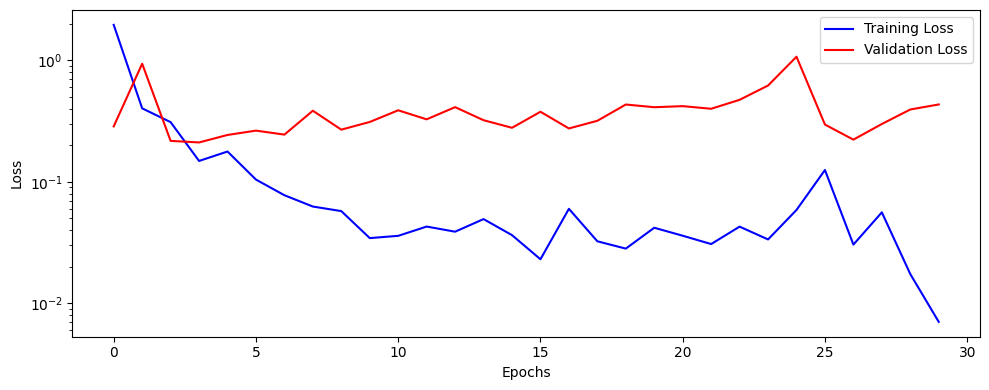

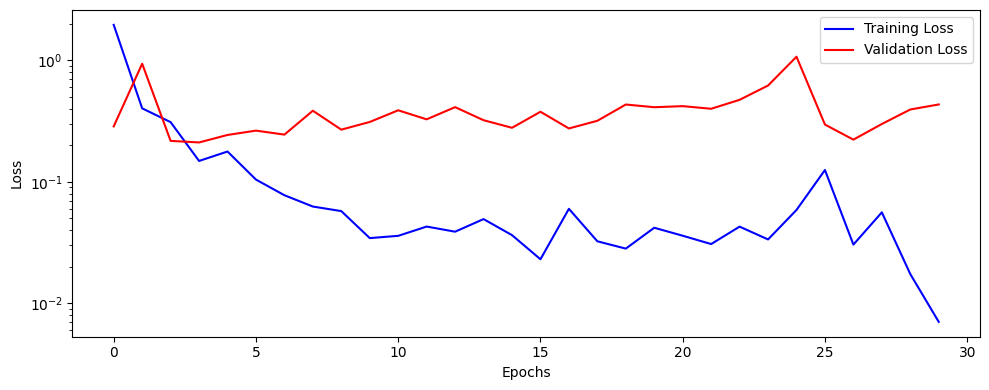

In [3]:
from new_model import ProtT5PrefixForSequenceClassification
from model_wo_prompt import ProtT5ForSequenceClassification
from dataset import PlantAMPDataset,LabelBalancedBatchSampler
from StepByStepForTraining import StepByStepForTraining
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import AutoConfig,T5Tokenizer,BertTokenizer
import re



n_epoch = 30
batch_size = 8
learning_rate =1.25E-03

pretrained_path="Rostlab/prot_t5_xl_uniref50"

tokenizer=T5Tokenizer.from_pretrained(pretrained_path, do_lower_case=False )

config = AutoConfig.from_pretrained(pretrained_path)
config.num_labels=2
config.classifier_dropout=0.1


#data preparation
train_path='../dataset/plant_train.csv'
train_dataset=PlantAMPDataset(train_path,tokenizer=tokenizer)
val_path='../dataset/plant_val.csv'
val_dataset=PlantAMPDataset(val_path,tokenizer=tokenizer)
test_path="../dataset/plant_test.csv"
test_dataset=PlantAMPDataset(test_path,tokenizer=tokenizer)
train_dataset1=PlantAMPDataset(train_path)


train_loader = torch.utils.data.DataLoader(
                          train_dataset,
                          batch_sampler=LabelBalancedBatchSampler(train_dataset, batch_size))
val_loader = torch.utils.data.DataLoader(
                          val_dataset,
                          batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(
                          test_dataset,
                          batch_size=batch_size)


def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        # nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)
            
#model configuration
model = ProtT5ForSequenceClassification.from_pretrained(pretrained_path,config=config)

with torch.no_grad():
    model.classifier.apply(weights_init)

# for param in model.classifier.parameters():
#     # param.requires_grad = False
#     param.requires_grad = True

# for param in model.transformer.parameters():
#     param.requires_grad = True

# # 使用LoRA进行微调
# lora_config = LoraConfig(
#     task_type=TaskType.SEQ_CLS,
#     r=8,
#     lora_alpha=32,
#     lora_dropout=0.1,
#     target_modules=["q", "v"]  # 针对多头注意力中的q和v矩阵
# )

# model = get_peft_model(model, lora_config)

 # Print number of trainable parameters
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print("ProtT5_Classfier\nTrainable Parameter: "+ str(params))    
 
# Add model modification lora
lora_config = LoRAConfig()

# Add LoRA layers
model = modify_with_lora(model, lora_config)
    
# Freeze Embeddings and Encoder (except LoRA)
# for (param_name, param) in model.shared.named_parameters():
#     param.requires_grad = False
# for (param_name, param) in model.encoder.named_parameters():
#     param.requires_grad = False       

for (param_name, param) in model.named_parameters():
    if re.fullmatch(lora_config.trainable_param_names, param_name):
        param.requires_grad = True
# Print trainable Parameter          
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print("ProtT5_LoRA_Classfier\nTrainable Parameter: "+ str(params) + "\n")


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# loss = nn.CrossEntropyLoss(reduction='sum')
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate,betas=(0.9, 0.999), eps=1e-8,weight_decay=1e-04)


sbs_contrasive = StepByStepForTraining(model, loss, optimizer)
sbs_contrasive.set_loaders(train_loader, val_loader, test_loader)

#for the lam=0.0
sbs_contrasive.set_accelerater(gradient_accumulation_steps=4)


#train for the classifier
sbs_contrasive.train_classifier(n_epoch,best_acc=0.9300)

sbs_contrasive.plot_losses()

In [9]:
filename = "../saved_model/fine-tuned_model"
# sbs_contrasive.save_checkpoint(filename)
def save_checkpoint(filename,sbs_contrasive):
    # Builds dictionary with all elements for resuming training
    checkpoint = {'epoch': sbs_contrasive.total_epochs,
                    # 'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': sbs_contrasive.optimizer.state_dict(),
                    # "tcl_optimizer_state_dict":self.tcl_optimizer.state_dict(),
                    'loss': sbs_contrasive.losses,
                    'val_loss': sbs_contrasive.val_losses,
                    # "TCL_loss":self.triple_loss_fn.state_dict()
                     }
    sbs_contrasive.model.save_pretrained(filename)
    checkpoint_filename = filename + "/checkpoint.pth"
    torch.save(checkpoint, checkpoint_filename)
save_checkpoint(filename,sbs_contrasive)


In [5]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve,RocCurveDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
# from scikitplot.metrics import plot_roc_curve

def display_conf_matrix(true_labels, pred_labels, pred_proba, classifier, savefile):
    
    # Display and Save Confusion Matrix:
    fig = plt.figure(figsize=(6,4), dpi=100)

    confusion_matrix1 = pd.crosstab(np.array(true_labels), 
                                   np.array(pred_labels),
                                   rownames=['Actual'], colnames=['Predicted'])
    confusion_matrix2 = pd.crosstab(np.array(true_labels), 
                                   np.array(pred_labels),
                                   rownames=['Actual'], colnames=['Predicted'], normalize='index')


    # Extracting counts and percentages from the matrices above:
    counts = ["{0:,}".format(value) for value in
                    confusion_matrix1.to_numpy().flatten()]

    percentages = ["{0:.2%}".format(value) for value in
                         confusion_matrix2.to_numpy().flatten()]

    # Combining counts and percentages as one label:
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(percentages, counts)]

    # Reshaping the labels to fit the array:
    labels = np.asarray(labels).reshape(2,2)

    #Plotting the heatmap:
    sns.heatmap(confusion_matrix2, annot=labels, fmt='', cmap='BuPu')
    plt.title("Confusion Matrix - %s\n" % classifier, fontweight='bold')
    plt.savefig(savefile, bbox_inches='tight')
    plt.show()

    # Calculating Metrics Using the Confusion Matrix:
    CM = confusion_matrix(true_labels, pred_labels, labels=[0, 1])

    TP = CM[1][1]
    FN = CM[1][0]
    FP = CM[0][1]
    TN = CM[0][0]

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    print(f"Sensitivity:     {TPR*100:.2f}%")
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    print(f"Specificity:     {TNR*100:.2f}%")
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)

    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    print(f"Accuracy:        {ACC*100:.2f}%") 

    # f1 Score:
    F1 = TP/(TP + (0.5*(FP+FN)))
    print(f"F1 Score:        {F1*100:.2f}%") 

    MCC = ((TP*TN)-(FP*FN))/ (((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))**0.5)
    print(f"MCC:             {MCC*100:.2f}%") 
    
    auROC = roc_auc_score(true_labels, pred_proba)
    print(f"auROC:           {auROC*100:.2f}%") 
    
    metrics = [TPR*100, TNR*100, ACC*100, F1*100, MCC*100, auROC*100]

    return metrics



In [3]:
def load_finetuned_checkpoint(model,filename):
    # Loads dictionary
    checkpoint_filename = filename + "/checkpoint.pth"
    checkpoint = torch.load(checkpoint_filename)

    # Restore state for model and optimizer
    model.load_state_dict(checkpoint['model_state_dict'])
    # model.classifier.load_state_dict(checkpoint['model_classifier_state_dict'])
    model.train() # always use TRAIN for resuming training   

In [4]:
import re
from new_model import ProtBertPrefix_ConvLayer1,ProtT5PrefixForSequenceClassification
from model_wo_prompt import ProtT5ForSequenceClassification
import torch
from torch.utils.data import DataLoader
from transformers import AutoConfig,T5Tokenizer,BertTokenizer
from dataset import AMPDataset,PlantAMPDataset
import numpy as np


loaded_path = '../saved_model/fine-tuned_model'


# pretrained_path='Rostlab/prot_bert'
pretrained_path="Rostlab/prot_t5_xl_uniref50"
config = AutoConfig.from_pretrained(loaded_path)

tokenizer=T5Tokenizer.from_pretrained(pretrained_path, do_lower_case=False )
batch_size=8
test_path="../dataset/plant_test.csv"
test_dataset=PlantAMPDataset(test_path,tokenizer=tokenizer)
test_loader = torch.utils.data.DataLoader(
                          test_dataset,
                          batch_size=batch_size)

model = ProtT5ForSequenceClassification.from_pretrained(pretrained_path,config=config)
# Add model modification lora
lora_config = LoRAConfig()

# Add LoRA layers
model = modify_with_lora(model, lora_config)
load_finetuned_checkpoint(model,loaded_path)



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
pred_labels=[]
real_labels=[]
pred_probabilaty=[]
model.eval()
for i, batch in enumerate(test_loader):
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels']
    outputs = model(input_ids,attention_mask).logits
    # print(outputs.shape)
    # print(torch.softmax(outputs,dim=1))
    pred_probabilaty.append(torch.softmax(outputs,dim=1).cpu().detach().numpy())
    pred_labels.append(outputs.argmax(dim=1).cpu().numpy())
    real_labels.append(labels.cpu().numpy())
real_labels = [np.concatenate(real_labels)]
pred_labels = [np.concatenate(pred_labels)]
real_labels = np.array(real_labels)
pred_labels= np.array(pred_labels)



pred_probabilaty= np.concatenate(pred_probabilaty)
pre_pro = pred_probabilaty[:, 1]
# real_labels = real_labels.reshape(-1, 1)
# pred_labels = pred_labels.reshape(-1, 1)
real_labels = real_labels.reshape(-1)
pred_labels = pred_labels.reshape(-1)
pre_pro = pre_pro.reshape(-1)

finetune_metrics = display_conf_matrix(real_labels, pred_labels, pre_pro, 'Finetune Model', '../Figures/Finetune Model.png')

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


total param is 689282


Some weights of the model checkpoint at Rostlab/prot_t5_xl_uniref50 were not used when initializing ProtT5ForSequenceClassification: ['decoder.block.0.layer.0.SelfAttention.k.weight', 'decoder.block.0.layer.0.SelfAttention.o.weight', 'decoder.block.0.layer.0.SelfAttention.q.weight', 'decoder.block.0.layer.0.SelfAttention.relative_attention_bias.weight', 'decoder.block.0.layer.0.SelfAttention.v.weight', 'decoder.block.0.layer.0.layer_norm.weight', 'decoder.block.0.layer.1.EncDecAttention.k.weight', 'decoder.block.0.layer.1.EncDecAttention.o.weight', 'decoder.block.0.layer.1.EncDecAttention.q.weight', 'decoder.block.0.layer.1.EncDecAttention.v.weight', 'decoder.block.0.layer.1.layer_norm.weight', 'decoder.block.0.layer.2.DenseReluDense.wi.weight', 'decoder.block.0.layer.2.DenseReluDense.wo.weight', 'decoder.block.0.layer.2.layer_norm.weight', 'decoder.block.1.layer.0.SelfAttention.k.weight', 'decoder.block.1.layer.0.SelfAttention.o.weight', 'decoder.block.1.layer.0.SelfAttention.q.weight

NameError: name 'display_conf_matrix' is not defined

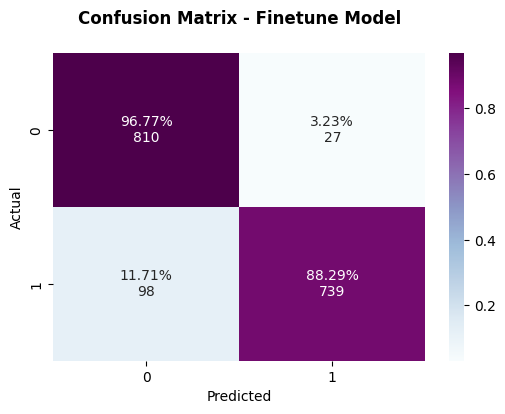

Sensitivity:     88.29%
Specificity:     96.77%
Accuracy:        92.53%
F1 Score:        92.20%
MCC:             85.37%
auROC:           97.05%


In [6]:
finetune_metrics = display_conf_matrix(real_labels, pred_labels, pre_pro, 'Finetune Model', '../Figures/Finetune Model.png')

In [7]:
metrics = finetune_metrics
dict={"Method": ['Fine-tuing'],
    "Sensitivity (%)": [metrics[0]],
      "Specificity (%)": [metrics[1]],
      "Accuracy (%)": [metrics[2]],
      "F1 Score (%)":[metrics[3]],
      "MCC (%)": [metrics[4]],
     "auROC (%)": [metrics[5]]
     }
# metrics_prompt_dataset = pd.DataFrame({ f'ContrastiveT5-Prompt20-Margin{config.margin}-lam{config.lam}':contrasive_t5_prompt20_metrics
#                             }).T.rename(
#                         columns={0: "Sensitivity (%)", 1: "Specificity (%)", 2: "Accuracy (%)", 
#                                  3: "F1 Score (%)", 4: "MCC (%)", 5: "auROC (%)"})

metrics_prompt_dataset = pd.DataFrame(dict)

In [8]:
metrics_prompt_dataset

,Method,Sensitivity (%),Specificity (%),Accuracy (%),F1 Score (%),MCC (%),auROC (%)
0,Fine-tuing,88.291517,96.774194,92.532855,92.202121,85.373421,97.051896


In [9]:
metrics_prompt_dataset.to_csv('../Results/Fine-Tuing_METRICS.csv',index=False)